In [188]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [189]:
def preprocess_data(df, target_col=None, le_dict=None, scaler=None):
    # Handle missing values
    # Technially not nesessary for this data because we have no null values, but if we did
    # this will replace the null value with the median or mode
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

    # Encode categorical features
    if le_dict is None:  # creates encoders
        le_dict = {}
        for col in df.select_dtypes(include=['object']).columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            le_dict[col] = le
    else:  #uses the encoders from the first dataset on the second so that the categorical values match
        for col in df.select_dtypes(include=['object']).columns:
            if col in le_dict:
                df[col] = le_dict[col].transform(df[col])
            else:
                raise ValueError(f"Unexpected categorical column: {col}")

    # Separate features and target
    if target_col and target_col in df.columns:
        X = df.drop(columns=[target_col], axis=1)
        y = df[[target_col]]
    else:
        X = df.copy()
        y = None

    # Standardize numerical features (exclude target if present)
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    if scaler is None:  # first dataset: fit scaler
        scaler = StandardScaler()
        X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    else:  # second dataset: use existing scaler
        X[numeric_cols] = scaler.transform(X[numeric_cols])

    return X, y, le_dict, scaler


In [190]:
#read in files
adult = pd.read_csv('project_adult.csv')
validation_inputs = pd.read_csv('project_validation_inputs.csv')

In [191]:
#actually preprocess the data
X_train, y_train, le_dict, scaler = preprocess_data(adult, target_col = "income")
X_test, y2, _, _ = preprocess_data(validation_inputs, target_col = "income", le_dict=le_dict, scaler=scaler)

/var/folders/5k/l0x65vls0y31fvwxvzx4xmpr0000gn/T/ipykernel_15941/1701664255.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/var/folders/5k/l0x65vls0y31fvwxvzx4xmpr0000gn/T/ipykernel_15941/1701664255.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [192]:
# Part 2: Implement Perceptron and Adaline algorithms
# Cote: Used code from in class work Iris adaline and perceptron
class Perceptron:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float64(0.)
        
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)


In [193]:
class AdalineGD:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float64(0.)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)          
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)


In [194]:
class AdalineSGD:
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float64(0.)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)


Training Perceptron model...


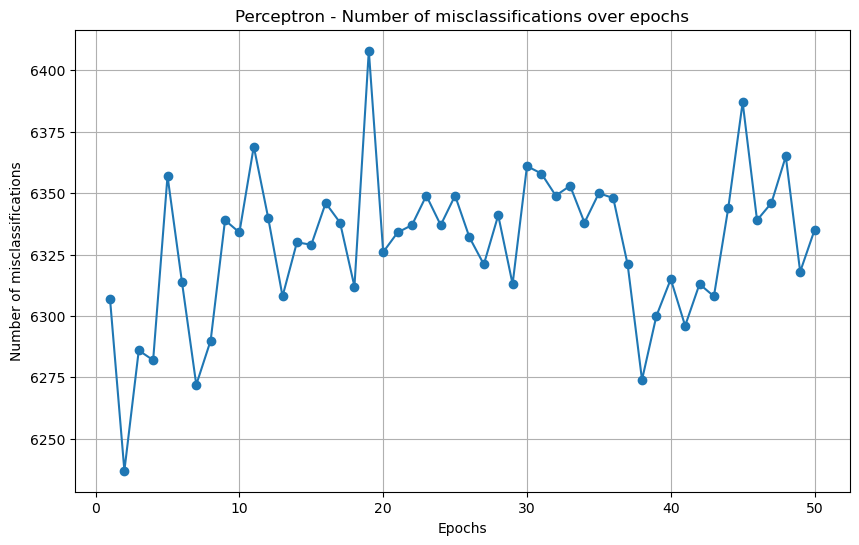

Perceptron final misclassifications: 6335
Perceptron converged: False
Training Accuracy (initial Perceptron): 0.7903869778869779


In [195]:
# Part 2a: Train Perceptron and Adaline models

# Convert y_train to 1D array for compatibility
y_train_1d = y_train.values.ravel()

# Train Perceptron model
print("Training Perceptron model...")
ppn = Perceptron(eta=0.1, n_iter=50, random_state=42)
ppn.fit(X_train.values, y_train_1d)

# Plot misclassifications over epochs for Perceptron
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of misclassifications')
plt.title('Perceptron - Number of misclassifications over epochs')
plt.grid(True)
plt.show()

print(f"Perceptron final misclassifications: {ppn.errors_[-1]}")
print(f"Perceptron converged: {ppn.errors_[-1] == 0}")
from sklearn.metrics import accuracy_score
print("Training Accuracy (initial Perceptron):", accuracy_score(y_train_1d, ppn.predict(X_train.values)))


Training AdalineGD model...
Training AdalineSGD model...


/var/folders/5k/l0x65vls0y31fvwxvzx4xmpr0000gn/T/ipykernel_15941/3416414581.py:51: RuntimeWarning: overflow encountered in scalar power
  loss = error**2
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


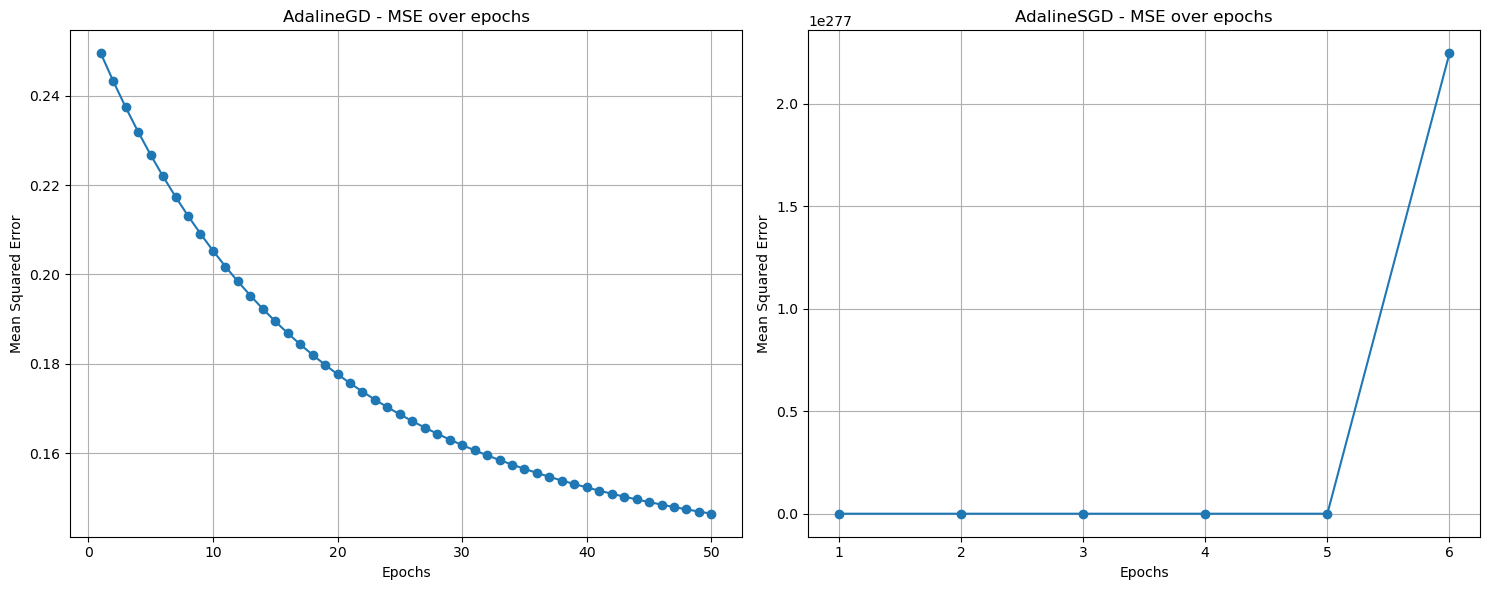

AdalineGD final MSE: 0.146441
AdalineSGD final MSE: nan


In [196]:
# Train AdalineGD model
print("Training AdalineGD model...")
ada_gd = AdalineGD(eta=0.01, n_iter=50, random_state=42)
ada_gd.fit(X_train.values, y_train_1d)

# Train AdalineSGD model
print("Training AdalineSGD model...")
ada_sgd = AdalineSGD(eta=0.01, n_iter=50, random_state=42)
ada_sgd.fit(X_train.values, y_train_1d)

# Plot MSE over epochs for both Adaline models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# AdalineGD plot
ax1.plot(range(1, len(ada_gd.losses_) + 1), ada_gd.losses_, marker='o')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('AdalineGD - MSE over epochs')
ax1.grid(True)

# AdalineSGD plot
ax2.plot(range(1, len(ada_sgd.losses_) + 1), ada_sgd.losses_, marker='o')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Mean Squared Error')
ax2.set_title('AdalineSGD - MSE over epochs')
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"AdalineGD final MSE: {ada_gd.losses_[-1]:.6f}")
print(f"AdalineSGD final MSE: {ada_sgd.losses_[-1]:.6f}")


Testing different hyperparameters for perceptron
Perceptron accuracy with n_iter 1 and eta 0: 0.4294
Perceptron accuracy with n_iter 1 and eta 0.25: 0.7697
Perceptron accuracy with n_iter 1 and eta 0.5: 0.7798
Perceptron accuracy with n_iter 1 and eta 0.75: 0.7692
Perceptron accuracy with n_iter 1 and eta 1: 0.7750
Perceptron accuracy with n_iter 2 and eta 0: 0.4294
Perceptron accuracy with n_iter 2 and eta 0.25: 0.7613
Perceptron accuracy with n_iter 2 and eta 0.5: 0.7673
Perceptron accuracy with n_iter 2 and eta 0.75: 0.7681
Perceptron accuracy with n_iter 2 and eta 1: 0.7598
Perceptron accuracy with n_iter 3 and eta 0: 0.4294
Perceptron accuracy with n_iter 3 and eta 0.25: 0.7567
Perceptron accuracy with n_iter 3 and eta 0.5: 0.7576
Perceptron accuracy with n_iter 3 and eta 0.75: 0.7713
Perceptron accuracy with n_iter 3 and eta 1: 0.7742
Perceptron accuracy with n_iter 5 and eta 0: 0.4294
Perceptron accuracy with n_iter 5 and eta 0.25: 0.7736
Perceptron accuracy with n_iter 5 and et

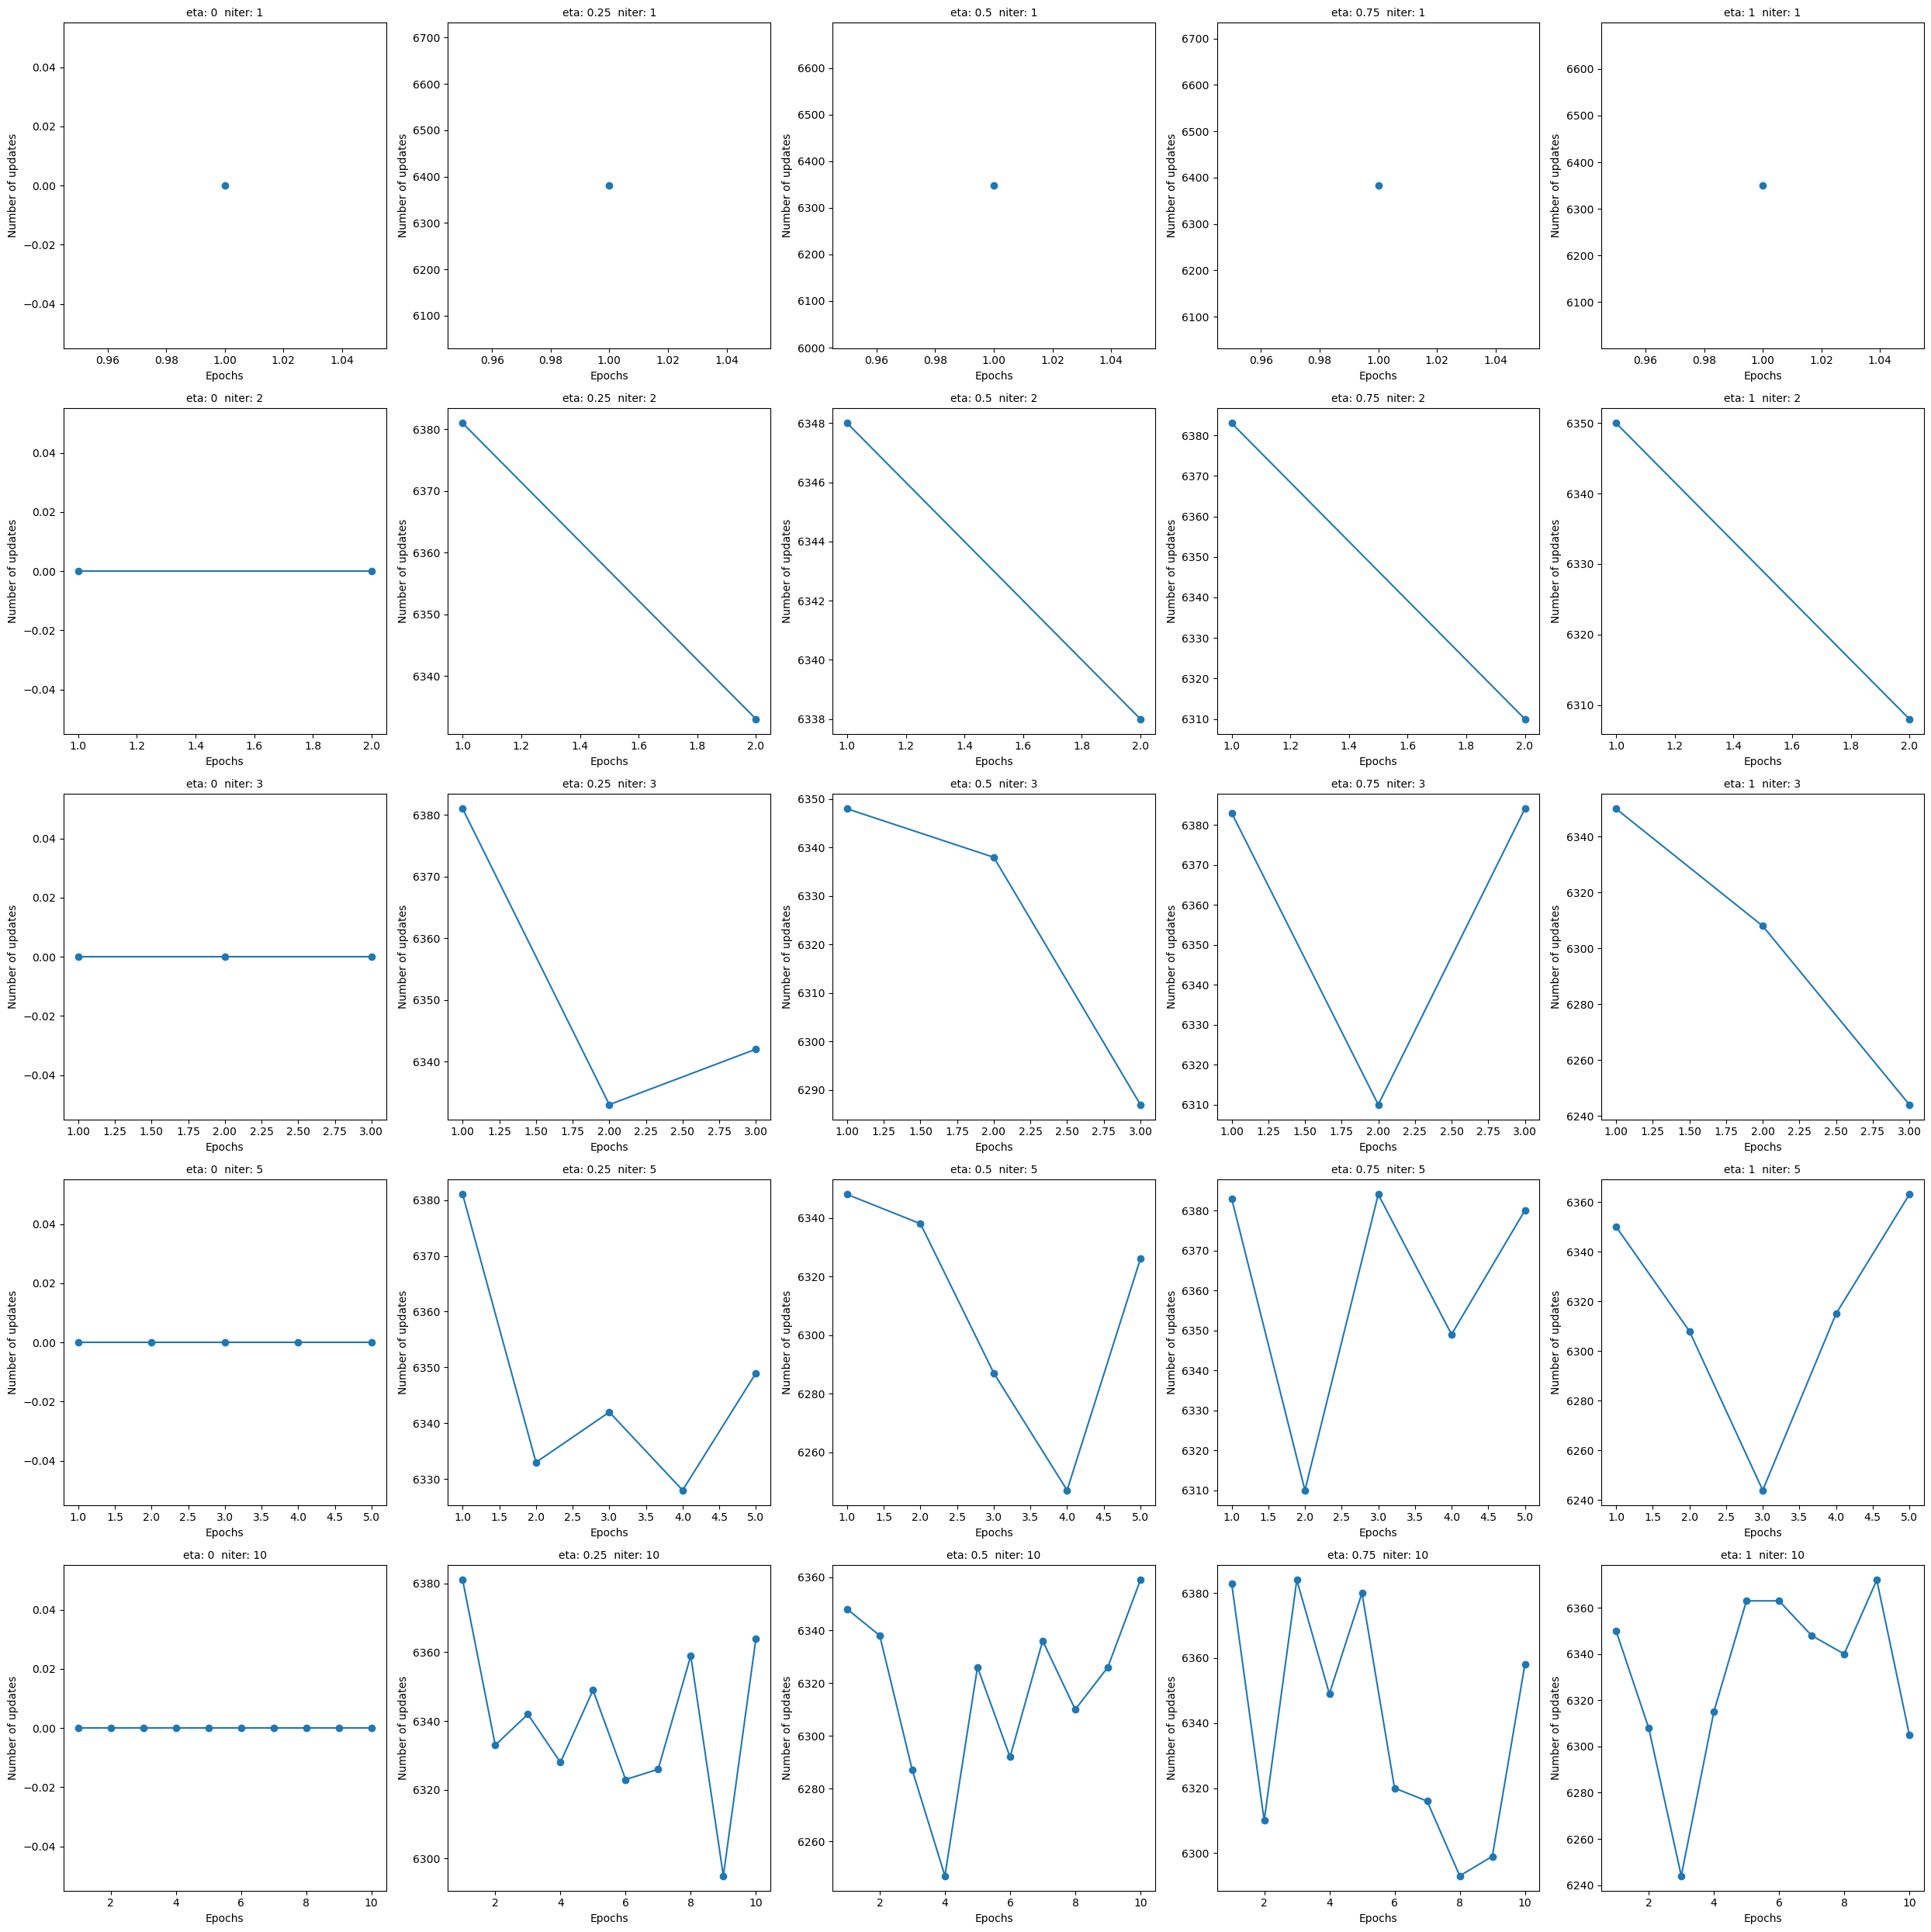


Best Perceptron: eta=0.25, n_iter=10, accuracy=0.7908


In [197]:
# Part 2c: Find the accuracy of best models from both algorithms

from sklearn.metrics import accuracy_score

# Test different hyperparameters for Perceptron using Iris assignment pattern
print("Testing different hyperparameters for perceptron")
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))

list_eta = [0, 0.25, 0.5, 0.75, 1]
list_niter = [1, 2, 3, 5, 10]



perceptron_results = []

for j, n_temp in enumerate(list_niter):
    for i, e_temp in enumerate(list_eta):
        ppn = Perceptron(n_iter=n_temp, eta=e_temp, random_state=42).fit(X_train.values, y_train_1d)
        ax[j, i].plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=10)
        ax[j, i].set_ylabel('Number of updates', fontsize=10)
        ax[j, i].set_title(f"eta: {e_temp}  niter: {n_temp}", fontsize=10)
        
        y_pred = ppn.predict(X_train.values)
        accuracy = accuracy_score(y_train_1d, y_pred)
        print(f"Perceptron accuracy with n_iter {n_temp} and eta {e_temp}: {accuracy:.4f}")
        perceptron_results.append((e_temp, n_temp, accuracy, ppn))

plt.tight_layout()
plt.show()

# Find best Perceptron
best_ppn_eta, best_ppn_iter, best_ppn_acc, best_ppn = max(perceptron_results, key=lambda x: x[2])
print(f"\nBest Perceptron: eta={best_ppn_eta}, n_iter={best_ppn_iter}, accuracy={best_ppn_acc:.4f}")



Testing different hyperparameters for AdalineGD
Adaline accuracy with n_iter 1 and eta 0.1: 0.7593
Adaline accuracy with n_iter 1 and eta 0.01: 0.7593
Adaline accuracy with n_iter 1 and eta 0.001: 0.7593
Adaline accuracy with n_iter 1 and eta 0.0001: 0.7593
Adaline accuracy with n_iter 1 and eta 1e-05: 0.7593
Adaline accuracy with n_iter 5 and eta 0.1: 0.7813
Adaline accuracy with n_iter 5 and eta 0.01: 0.7593
Adaline accuracy with n_iter 5 and eta 0.001: 0.7593
Adaline accuracy with n_iter 5 and eta 0.0001: 0.7593
Adaline accuracy with n_iter 5 and eta 1e-05: 0.7593
Adaline accuracy with n_iter 10 and eta 0.1: 0.7999
Adaline accuracy with n_iter 10 and eta 0.01: 0.7593
Adaline accuracy with n_iter 10 and eta 0.001: 0.7593
Adaline accuracy with n_iter 10 and eta 0.0001: 0.7593
Adaline accuracy with n_iter 10 and eta 1e-05: 0.7593
Adaline accuracy with n_iter 15 and eta 0.1: 0.8062
Adaline accuracy with n_iter 15 and eta 0.01: 0.7601
Adaline accuracy with n_iter 15 and eta 0.001: 0.759

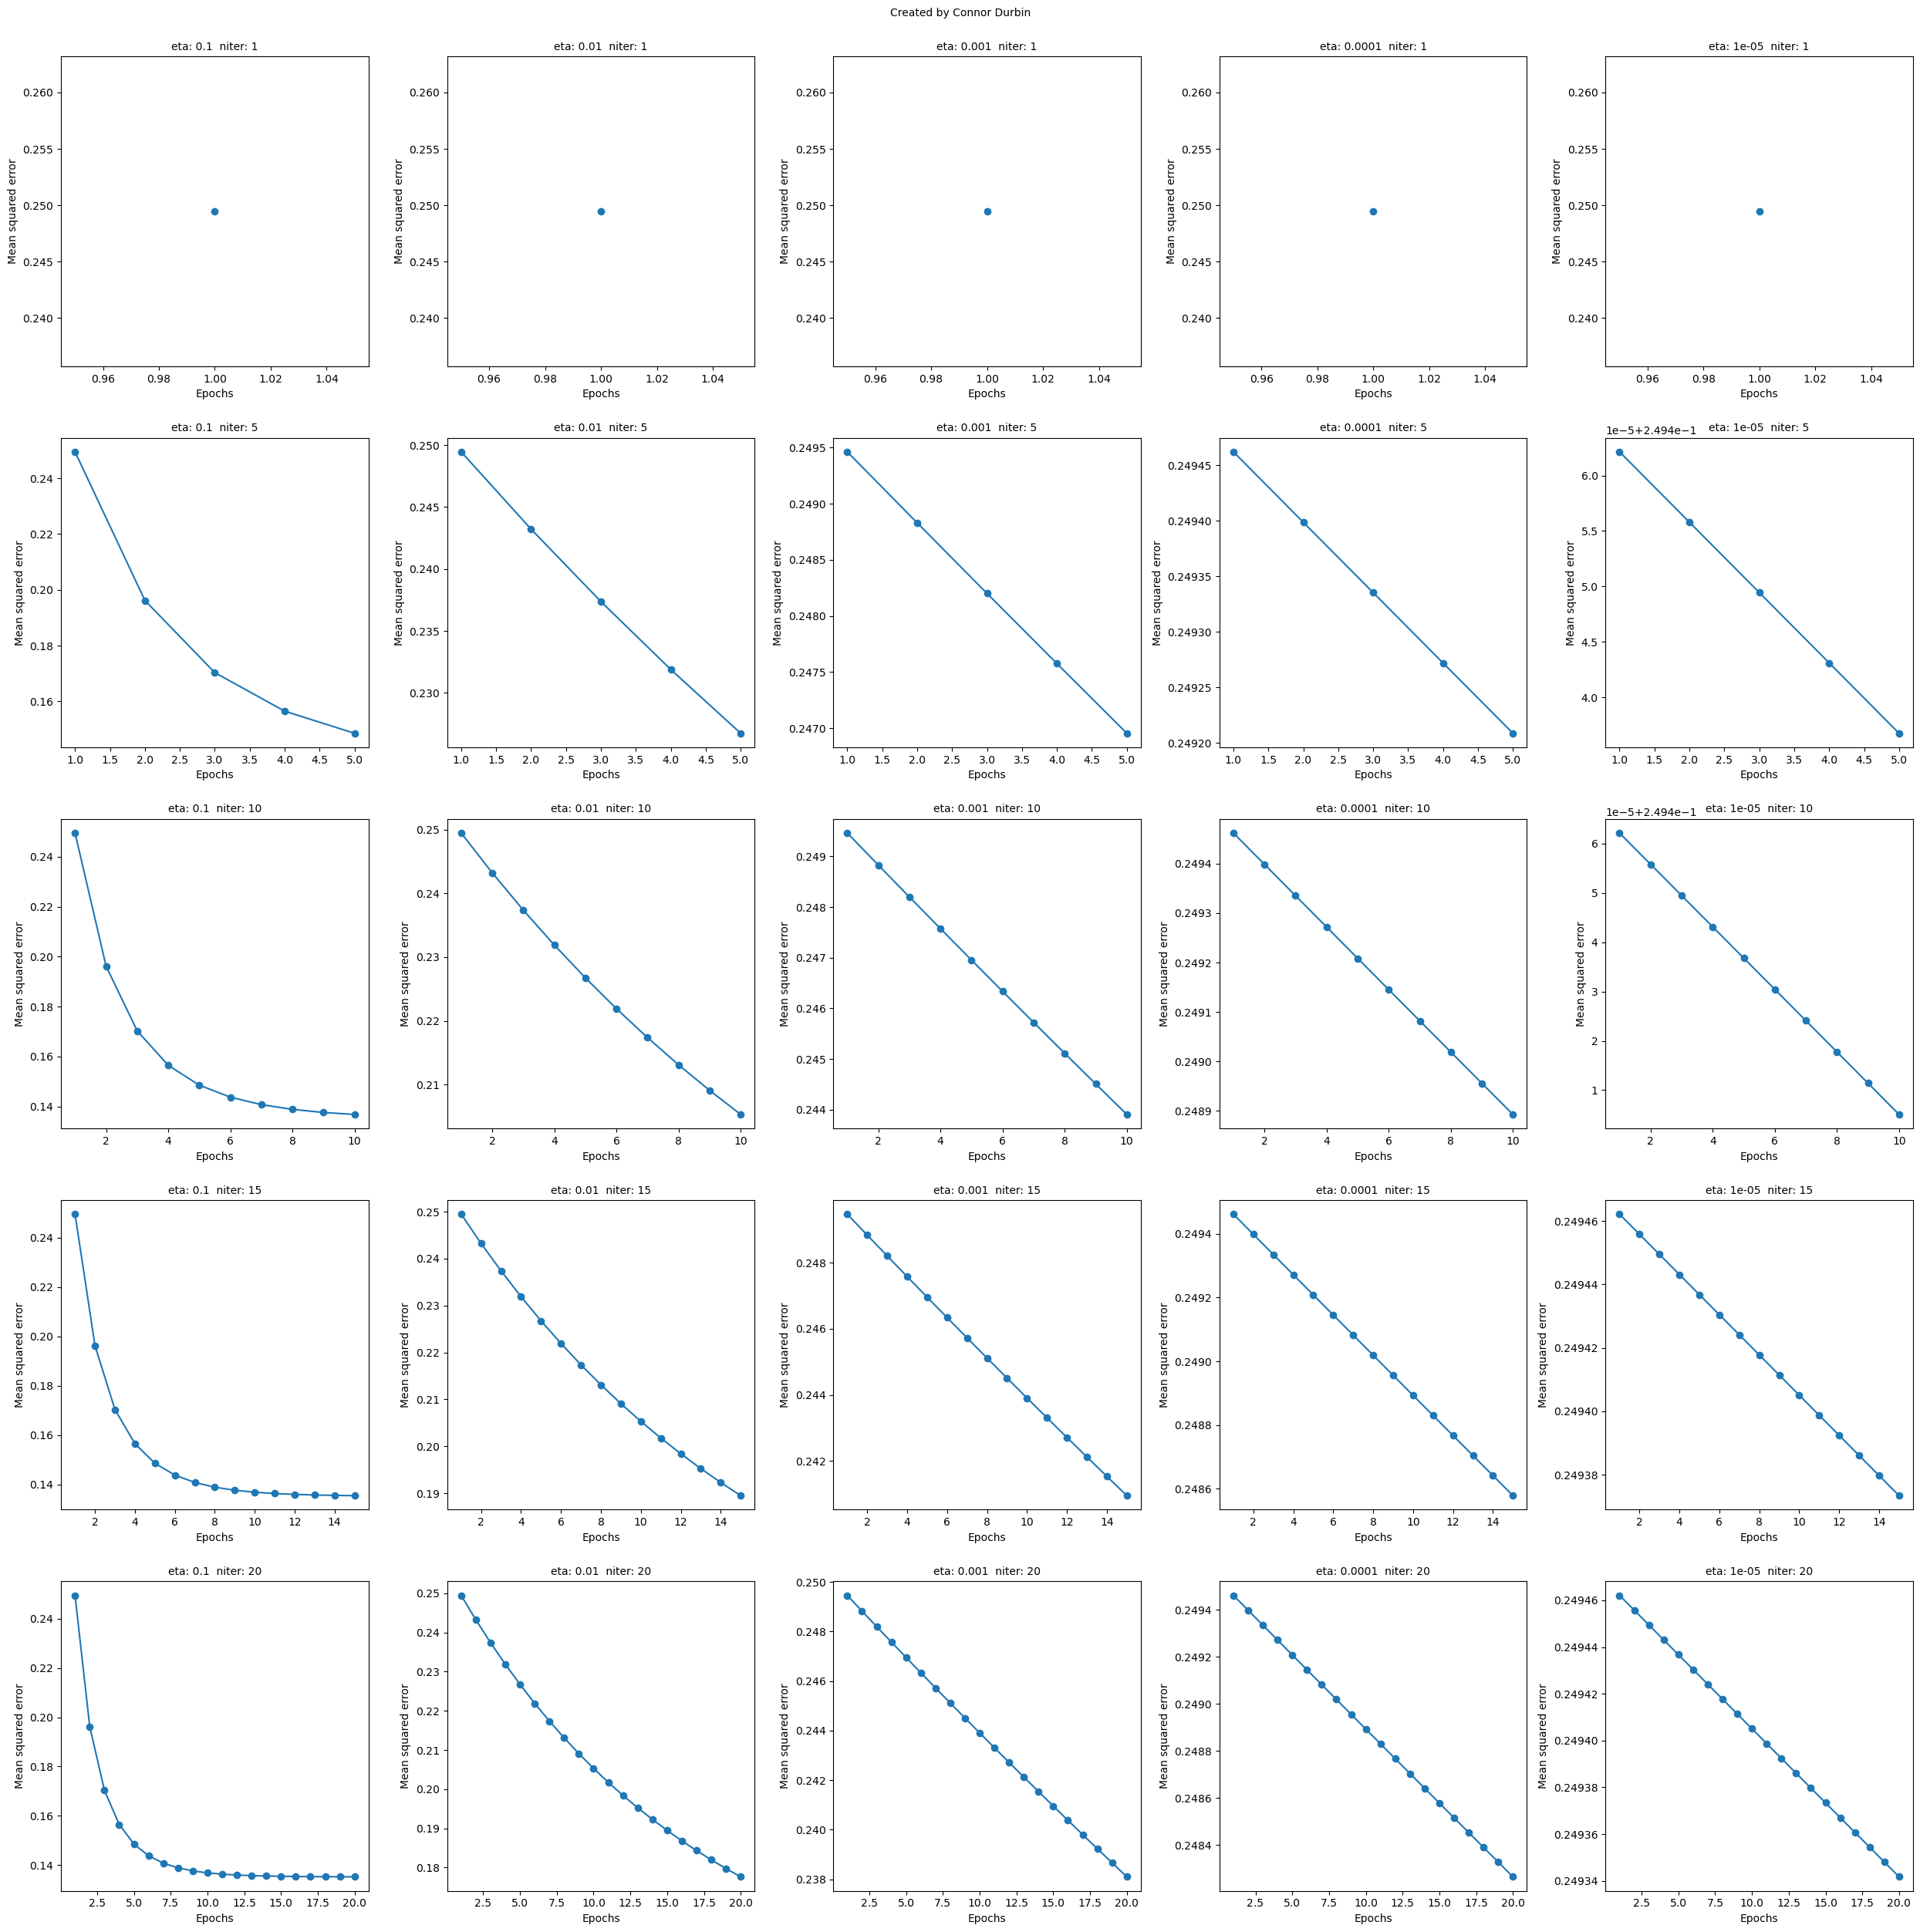


Best AdalineGD: eta=0.1, n_iter=20, accuracy=0.8078


In [198]:
# Test different hyperparameters for AdalineGD 
print("\nTesting different hyperparameters for AdalineGD")
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))

list_eta = [.1, 0.01, 0.001, 0.0001, 0.00001]
list_niter = [1, 5, 10, 15, 20]

fig.suptitle("Created by Connor Durbin", fontsize=10, y=1)

adaline_gd_results = []

for j, n_temp in enumerate(list_niter):
    for i, e_temp in enumerate(list_eta):
        ada = AdalineGD(n_iter=n_temp, eta=e_temp, random_state=42).fit(X_train.values, y_train_1d)
        ax[j, i].plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=10)
        ax[j, i].set_ylabel('Mean squared error', fontsize=10)
        ax[j, i].set_title(f"eta: {e_temp}  niter: {n_temp}", fontsize=10)
        
        y_pred = ada.predict(X_train.values)
        accuracy = accuracy_score(y_train_1d, y_pred)
        print(f"Adaline accuracy with n_iter {n_temp} and eta {e_temp}: {accuracy:.4f}")
        adaline_gd_results.append((e_temp, n_temp, accuracy, ada))

plt.tight_layout()
plt.show()

# Find best AdalineGD
best_ada_gd_eta, best_ada_gd_iter, best_ada_gd_acc, best_ada_gd = max(adaline_gd_results, key=lambda x: x[2])
print(f"\nBest AdalineGD: eta={best_ada_gd_eta}, n_iter={best_ada_gd_iter}, accuracy={best_ada_gd_acc:.4f}")



Testing different hyperparameters for AdalineSGD
AdalineSGD accuracy with n_iter 1 and eta 0.1: 0.7593
AdalineSGD accuracy with n_iter 1 and eta 0.01: 0.5997


/var/folders/5k/l0x65vls0y31fvwxvzx4xmpr0000gn/T/ipykernel_15941/3416414581.py:51: RuntimeWarning: overflow encountered in scalar power
  loss = error**2
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


AdalineSGD accuracy with n_iter 1 and eta 0.001: 0.8094
AdalineSGD accuracy with n_iter 1 and eta 0.0001: 0.8063
AdalineSGD accuracy with n_iter 1 and eta 1e-05: 0.7638


/var/folders/5k/l0x65vls0y31fvwxvzx4xmpr0000gn/T/ipykernel_15941/3416414581.py:51: RuntimeWarning: overflow encountered in scalar power
  loss = error**2
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


AdalineSGD accuracy with n_iter 5 and eta 0.1: 0.7593
AdalineSGD accuracy with n_iter 5 and eta 0.01: 0.5859
AdalineSGD accuracy with n_iter 5 and eta 0.001: 0.8089
AdalineSGD accuracy with n_iter 5 and eta 0.0001: 0.8084
AdalineSGD accuracy with n_iter 5 and eta 1e-05: 0.8026


/var/folders/5k/l0x65vls0y31fvwxvzx4xmpr0000gn/T/ipykernel_15941/3416414581.py:51: RuntimeWarning: overflow encountered in scalar power
  loss = error**2
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


AdalineSGD accuracy with n_iter 10 and eta 0.1: 0.7593


/var/folders/5k/l0x65vls0y31fvwxvzx4xmpr0000gn/T/ipykernel_15941/3416414581.py:51: RuntimeWarning: overflow encountered in scalar power
  loss = error**2
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


AdalineSGD accuracy with n_iter 10 and eta 0.01: 0.4248
AdalineSGD accuracy with n_iter 10 and eta 0.001: 0.8158
AdalineSGD accuracy with n_iter 10 and eta 0.0001: 0.8107
AdalineSGD accuracy with n_iter 10 and eta 1e-05: 0.8084


/var/folders/5k/l0x65vls0y31fvwxvzx4xmpr0000gn/T/ipykernel_15941/3416414581.py:51: RuntimeWarning: overflow encountered in scalar power
  loss = error**2
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


AdalineSGD accuracy with n_iter 15 and eta 0.1: 0.7593


/var/folders/5k/l0x65vls0y31fvwxvzx4xmpr0000gn/T/ipykernel_15941/3416414581.py:51: RuntimeWarning: overflow encountered in scalar power
  loss = error**2
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


AdalineSGD accuracy with n_iter 15 and eta 0.01: 0.7593
AdalineSGD accuracy with n_iter 15 and eta 0.001: 0.8024
AdalineSGD accuracy with n_iter 15 and eta 0.0001: 0.8093
AdalineSGD accuracy with n_iter 15 and eta 1e-05: 0.8086


/var/folders/5k/l0x65vls0y31fvwxvzx4xmpr0000gn/T/ipykernel_15941/3416414581.py:51: RuntimeWarning: overflow encountered in scalar power
  loss = error**2
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


AdalineSGD accuracy with n_iter 20 and eta 0.1: 0.7593


/var/folders/5k/l0x65vls0y31fvwxvzx4xmpr0000gn/T/ipykernel_15941/3416414581.py:51: RuntimeWarning: overflow encountered in scalar power
  loss = error**2
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


AdalineSGD accuracy with n_iter 20 and eta 0.01: 0.7593
AdalineSGD accuracy with n_iter 20 and eta 0.001: 0.8006
AdalineSGD accuracy with n_iter 20 and eta 0.0001: 0.8073
AdalineSGD accuracy with n_iter 20 and eta 1e-05: 0.8089


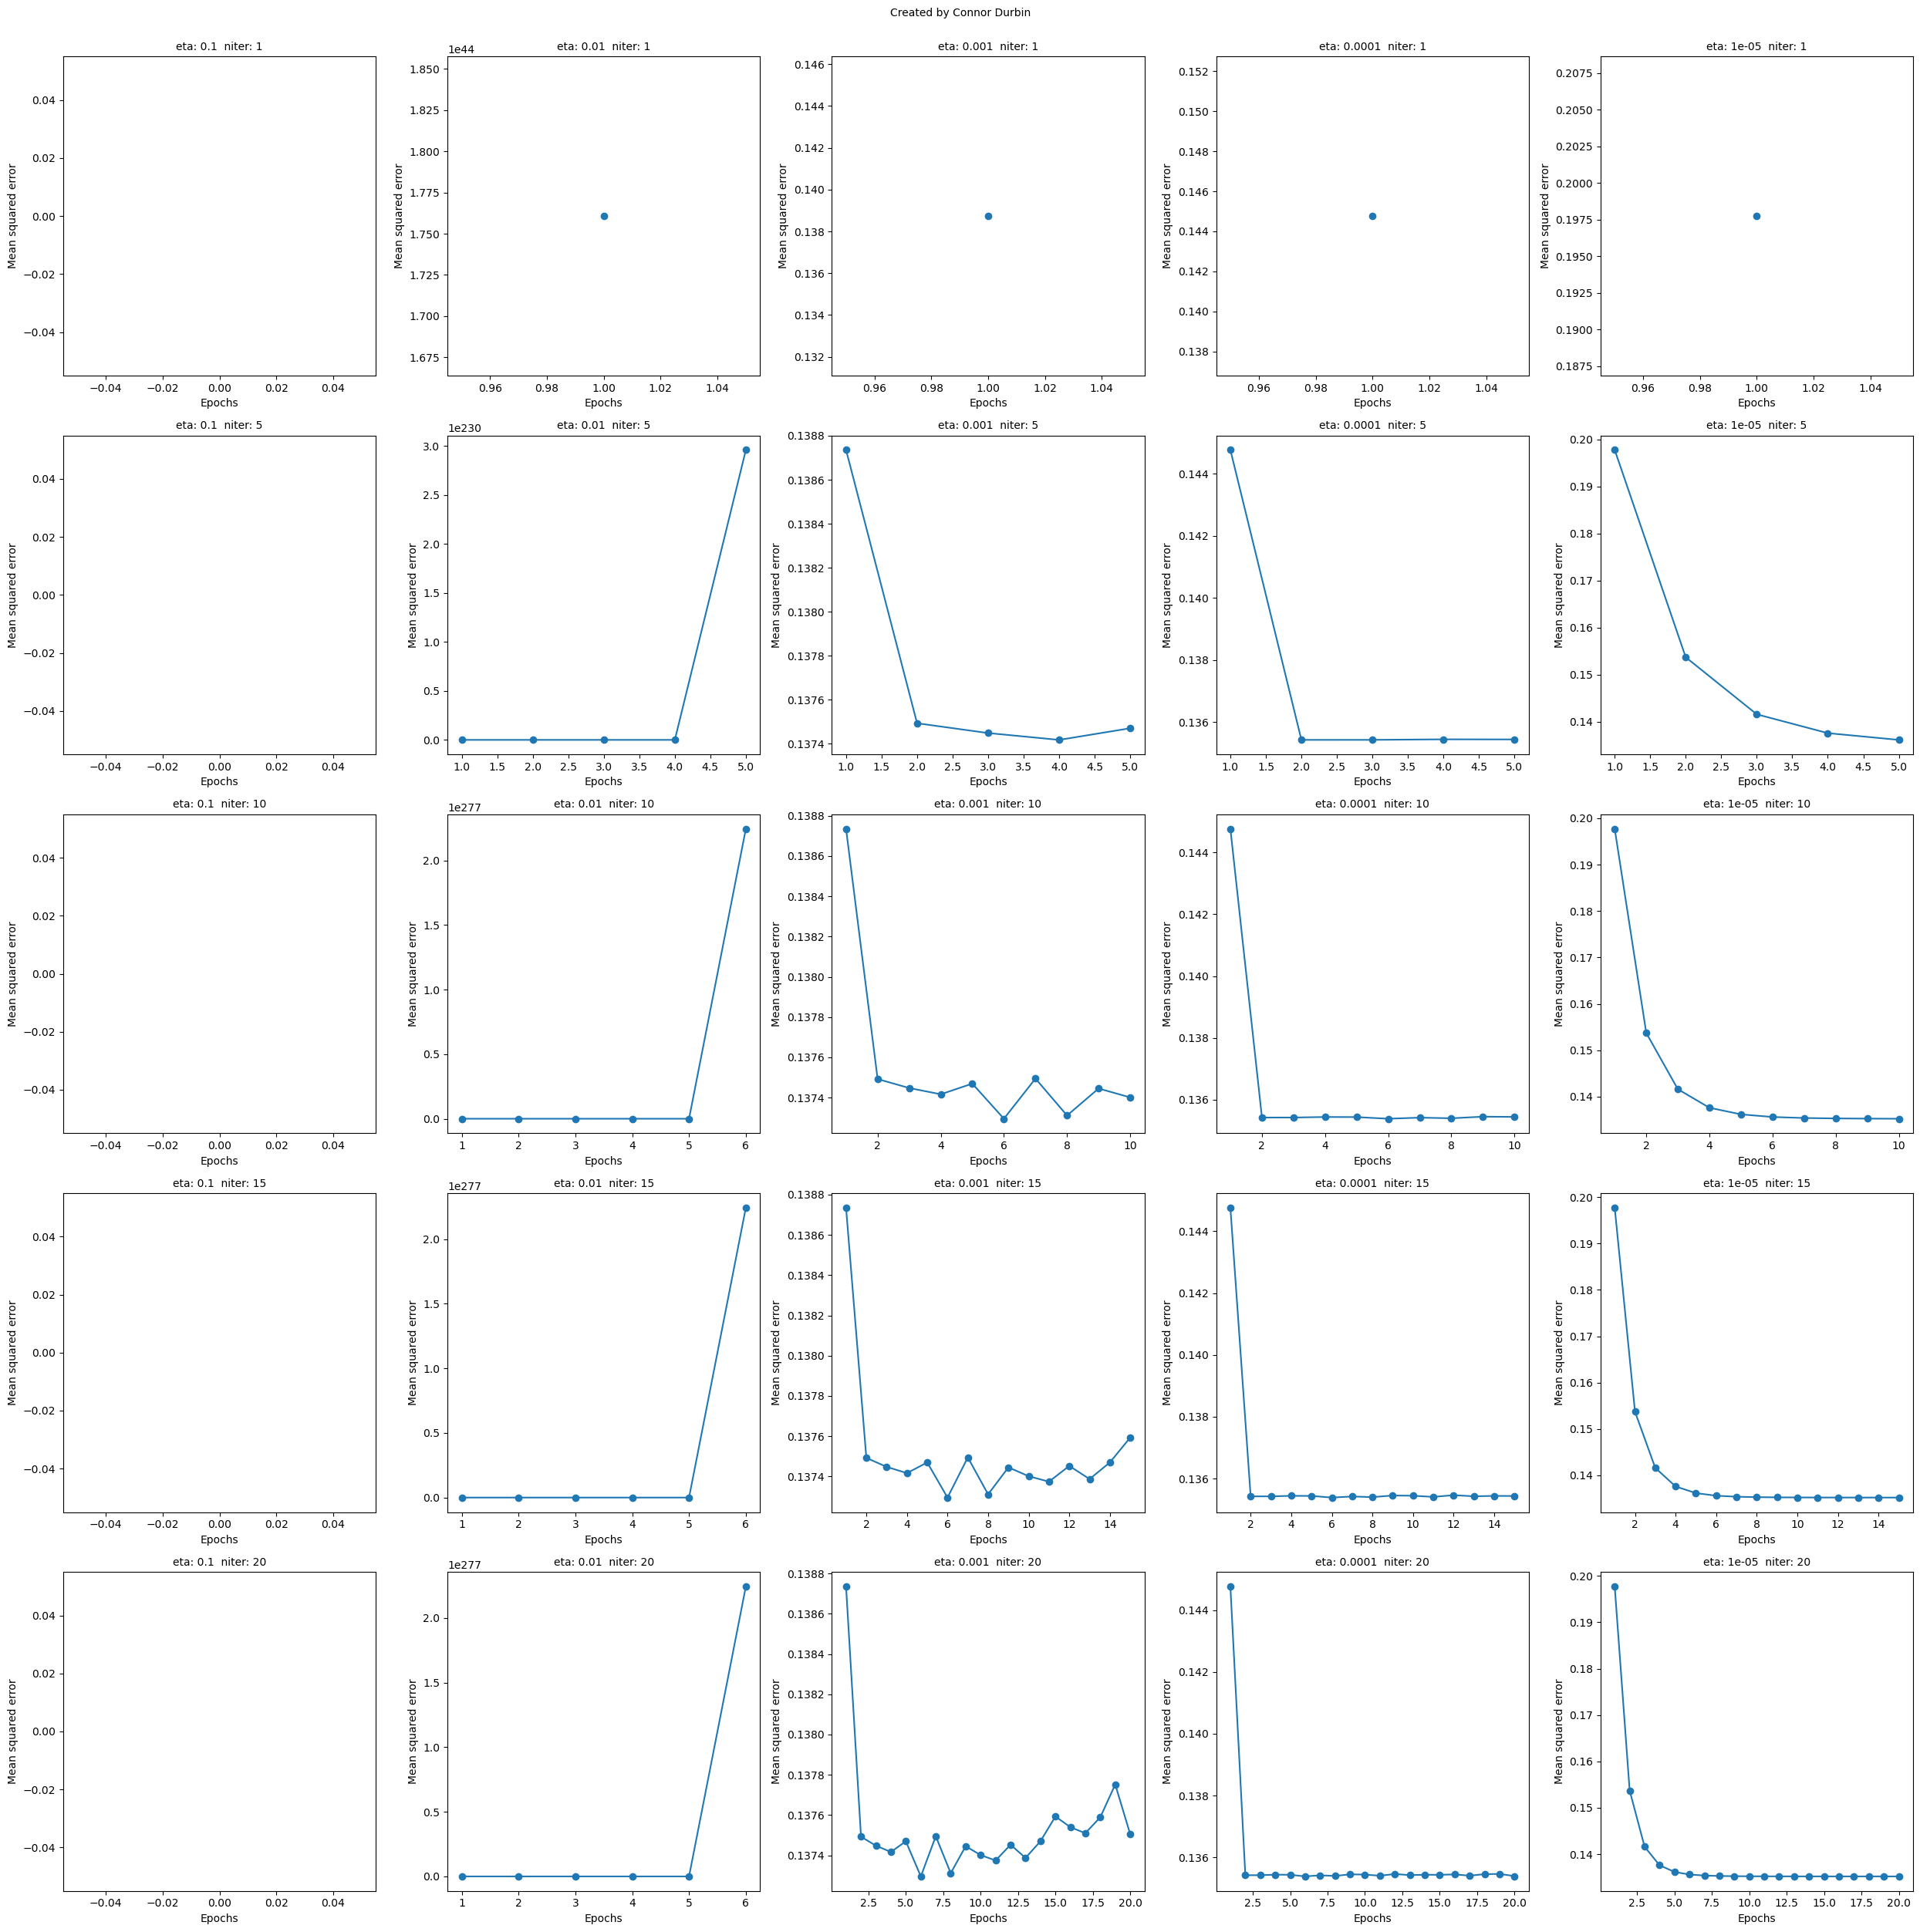


Best AdalineSGD: eta=0.001, n_iter=10, accuracy=0.8158

Model Comparison (Training Accuracy):
Perceptron: 0.7908
AdalineGD: 0.8078
AdalineSGD: 0.8158


In [199]:
# Test different hyperparameters for AdalineSGD 
print("\nTesting different hyperparameters for AdalineSGD")
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))

list_eta = [.1, 0.01, 0.001, 0.0001, 0.00001]
list_niter = [1, 5, 10, 15, 20]

fig.suptitle("Created by Connor Durbin", fontsize=10, y=1)

adaline_sgd_results = []

for j, n_temp in enumerate(list_niter):
    for i, e_temp in enumerate(list_eta):
        ada = AdalineSGD(n_iter=n_temp, eta=e_temp, random_state=42).fit(X_train.values, y_train_1d)
        ax[j, i].plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=10)
        ax[j, i].set_ylabel('Mean squared error', fontsize=10)
        ax[j, i].set_title(f"eta: {e_temp}  niter: {n_temp}", fontsize=10)
        
        y_pred = ada.predict(X_train.values)
        accuracy = accuracy_score(y_train_1d, y_pred)
        print(f"AdalineSGD accuracy with n_iter {n_temp} and eta {e_temp}: {accuracy:.4f}")
        adaline_sgd_results.append((e_temp, n_temp, accuracy, ada))

plt.tight_layout()
plt.show()

# Find best AdalineSGD
best_ada_sgd_eta, best_ada_sgd_iter, best_ada_sgd_acc, best_ada_sgd = max(adaline_sgd_results, key=lambda x: x[2])
print(f"\nBest AdalineSGD: eta={best_ada_sgd_eta}, n_iter={best_ada_sgd_iter}, accuracy={best_ada_sgd_acc:.4f}")

# Compare all best models
print(f"\nModel Comparison (Training Accuracy):")
print(f"Perceptron: {best_ppn_acc:.4f}")
print(f"AdalineGD: {best_ada_gd_acc:.4f}")
print(f"AdalineSGD: {best_ada_sgd_acc:.4f}")


In [200]:
# Part 2d: Use best performing models to predict outputs for project_validation_inputs

print("Making predictions on validation data using best models")

# Predict using best Perceptron
y_pred_ppn = best_ppn.predict(X_test.values)
print(f"Perceptron predictions shape: {y_pred_ppn.shape}")

# Predict using best AdalineGD
y_pred_ada_gd = best_ada_gd.predict(X_test.values)
print(f"AdalineGD predictions shape: {y_pred_ada_gd.shape}")

# Predict using best AdalineSGD
y_pred_ada_sgd = best_ada_sgd.predict(X_test.values)
print(f"AdalineSGD predictions shape: {y_pred_ada_sgd.shape}")

# Create a DataFrame with all predictions
validation_predictions = pd.DataFrame({
    'Perceptron': y_pred_ppn,
    'AdalineGD': y_pred_ada_gd,
    'AdalineSGD': y_pred_ada_sgd
})

print("\nFirst 10 predictions from each model:")
print(validation_predictions.head(10))

# Save predictions to CSV
validation_predictions.to_csv('group_4_validation_predictions.csv', index=False)
print("\nPredictions saved to 'group_4_validation_predictions.csv'")


Making predictions on validation data using best models
Perceptron predictions shape: (6513,)
AdalineGD predictions shape: (6513,)
AdalineSGD predictions shape: (6513,)

First 10 predictions from each model:
   Perceptron  AdalineGD  AdalineSGD
0           0          0           0
1           0          0           0
2           0          0           0
3           0          0           0
4           0          0           0
5           1          1           1
6           1          1           1
7           0          0           0
8           0          0           0
9           0          0           0

Predictions saved to 'group_4_validation_predictions.csv'


In [201]:
# Part 2e: Use scikit-learn's Perceptron and compare with custom implementations

from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier

print("Training scikit-learn models...")

# Train scikit-learn Perceptron
sklearn_ppn = SklearnPerceptron(random_state=42, max_iter=1000)
sklearn_ppn.fit(X_train.values, y_train_1d)

# Train SGDClassifier (similar to AdalineSGD)
sklearn_sgd = SGDClassifier(loss='perceptron', random_state=42, max_iter=1000)
sklearn_sgd.fit(X_train.values, y_train_1d)

# Calculate training accuracy for sklearn models
sklearn_ppn_train_acc = sklearn_ppn.score(X_train.values, y_train_1d)
sklearn_sgd_train_acc = sklearn_sgd.score(X_train.values, y_train_1d)

print(f"\nScikit-learn model training accuracies:")
print(f"Sklearn Perceptron: {sklearn_ppn_train_acc:.4f}")
print(f"Sklearn SGD (Perceptron): {sklearn_sgd_train_acc:.4f}")

# Compare with our custom implementations
print(f"\nComparison of all models (Training Accuracy):")
print(f"Custom Perceptron: {best_ppn_acc:.4f}")
print(f"Custom AdalineGD: {best_ada_gd_acc:.4f}")
print(f"Custom AdalineSGD: {best_ada_sgd_acc:.4f}")
print(f"Sklearn Perceptron: {sklearn_ppn_train_acc:.4f}")
print(f"Sklearn SGD (Perceptron): {sklearn_sgd_train_acc:.4f}")

# Make predictions on validation data using sklearn models
y_pred_sklearn_ppn = sklearn_ppn.predict(X_test.values)
y_pred_sklearn_sgd = sklearn_sgd.predict(X_test.values)

# Add sklearn predictions to our validation predictions DataFrame
validation_predictions['Sklearn_Perceptron'] = y_pred_sklearn_ppn
validation_predictions['Sklearn_SGD'] = y_pred_sklearn_sgd

print(f"\nUpdated validation predictions with sklearn models:")
print(validation_predictions.head(10))

# Save updated predictions
validation_predictions.to_csv('part2_validation_predictions_with_sklearn.csv', index=False)
print("\nUpdated predictions saved to 'Group_4_validation_predictions_FINAL.csv'")


Training scikit-learn models...

Scikit-learn model training accuracies:
Sklearn Perceptron: 0.7522
Sklearn SGD (Perceptron): 0.7393

Comparison of all models (Training Accuracy):
Custom Perceptron: 0.7908
Custom AdalineGD: 0.8078
Custom AdalineSGD: 0.8158
Sklearn Perceptron: 0.7522
Sklearn SGD (Perceptron): 0.7393

Updated validation predictions with sklearn models:
   Perceptron  AdalineGD  AdalineSGD  Sklearn_Perceptron  Sklearn_SGD
0           0          0           0                   1            1
1           0          0           0                   0            0
2           0          0           0                   0            1
3           0          0           0                   1            0
4           0          0           0                   1            1
5           1          1           1                   0            1
6           1          1           1                   1            1
7           0          0           0                   0            0
